In [1]:
from tensorflow import keras
from deepcell_spots.dotnet import dot_net_2D
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler
from deepcell_spots import losses
from deepcell_spots.point_metrics import *
from deepcell_spots.sim_em_data import *
from deepcell_spots.cluster_vis import *
from deepcell_spots.cp_benchmarking import *
from deepcell_spots.spot_em import *
from deepcell_spots.simulated_image_generators import gaussian_spot_image_generator
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Set up directories

In [2]:
data_dir = '/data/20201208-training_data/'
autofluor_dir = '/data/20201006-for_simulated_spots/'
image_files = glob.glob(autofluor_dir + 'MAX*')
image_files = image_files[:3]
image_files

['/data/20201006-for_simulated_spots/MAX_20200702-SeqFISH-HEK293T17_0nMp_50nMs001.nd2 - C=3.tif',
 '/data/20201006-for_simulated_spots/MAX_20200702-SeqFISH-HEK293T17_0nMp_50nMs001.nd2 - C=1.tif',
 '/data/20201006-for_simulated_spots/MAX_20200702-SeqFISH-HEK293T17_0nMp_50nMs.nd2 - C=3.tif']

In [3]:
im_stack = []
blur_stack = []
# Add tiff images to the stack
dim_output = 128
for item in image_files:
    # Read in images one at a time
    im = np.array(Image.open(item))
    blur = cv2.GaussianBlur(im,(5,5),0)
    # Get dimensions of existing stack
    dim_x = np.shape(im)[1]
    dim_y = np.shape(im)[0]
    
    # Calculate the number of slices of that size in loaded image
    x_slices = int(dim_x/dim_output)
    y_slices = int(dim_y/dim_output)
    
    # Create sliced images from loaded image and add to stack
    for i in range(x_slices):
        for ii in range(y_slices):
            im_slice = im[ii*dim_output:(ii+1)*dim_output,i*dim_output:(i+1)*dim_output]
            blur_slice = blur[ii*dim_output:(ii+1)*dim_output,i*dim_output:(i+1)*dim_output]
#             if all(i<500 for i in np.ndarray.flatten(im_slice)):
#                 min_int = min(map(min,im_slice))
#                 max_int = max(map(max,im_slice))
#                 norm_im = (im_slice-min_int)/(max_int-min_int)
#                 im_stack.append(norm_im)

            im_stack.append(im_slice)
            blur_stack.append(blur_slice)

im_stack = np.expand_dims(im_stack, axis=-1)
blur_stack = np.expand_dims(blur_stack, axis=-1)
np.shape(im_stack)

(432, 128, 128, 1)

In [4]:
model_dir = '/data/20201208-training_data/models/'

em_weights_file = glob.glob(model_dir + '*em.h5')
sim_weights_file = glob.glob(model_dir + '*sim.h5')
em_weights_file

['/data/20201208-training_data/models/conv_dots_model_em.h5']

In [5]:
exp_image_files = glob.glob(data_dir + 'images/*')
exp_image_files

['/data/20201208-training_data/images/20201208-em_output_images.npy']

In [6]:
exp_im_stack = np.load(exp_image_files[0], allow_pickle=True)
exp_im_stack = np.expand_dims(exp_im_stack, axis=-1)
np.shape(exp_im_stack)

(588, 128, 128, 1)

# Simulate spots

Creating ground truth annotations for the locations of spots in RNA FISH image data sets is extremely time consuming and difficult. This limitation can make it difficult to benchmark the performance of our deep learning spot detection models, because there is no ground truth annotations to compare the model output against. Therefore, we simulate RNA FISH images to test the performance of our spot detection models, because the locations of all of the spots are known in simulated images. 

To create simulated images, we approximate the fluorescent RNA molecules as Gaussian functions. The images of Gaussian objects are added to images of cell autofluorescence to simulate the expected fluorescent background seen in experimental RNA FISH images. The size and intensity of the Gaussian objects relative to the autofluorescence background approximately match the size and intensity of the fluorescent objects seen in experimental RNA FISH images -- prove later. The spots are uniformly distributed throughout the image. We vary the density of the spots in the images to sample the different densities of spots typically seen in RNA FISH datasets. 

In [7]:
num_images = 200 #len(im_stack) #1000 # number of images to generate
L = 128 # square image side length
N_min_list = np.arange(10,100,20) #50 # number of dots in the image uniformly distributed between N_min and N_max
N_max_list = np.arange(50,500,100) #100
sigma_mean = 1 # mean sigma of gaussian dot
sigma_std = 0.1 # deviation from sigma
A_mean = 4 # intensity of gaussian
A_std = 1 # intensity of gaussian
noise_mean = 0 # white noise added to entire image - mean and std
noise_std = 0 #0.01

In [8]:
sim_spots_all = []
coords_all = []

for i in range(len(N_min_list)):
    g = gaussian_spot_image_generator(L, N_min_list[i], N_max_list[i], sigma_mean, sigma_std, A_mean, A_std, noise_mean = noise_mean, noise_std = noise_std,segmask=True,yield_pos=True)

    X = []
    y = []

    for ind in range(num_images):
        img, label, x_list, y_list, bboxes = next(g)
        dot_coords = np.array([y_list, x_list]).T

        X.append(np.expand_dims(img,axis=-1)) # add channel axis (add channel support later)
        y.append(dot_coords)
    
    sim_spots_all.append(np.array(X))
    coords_all.append(np.array(y))
    
sim_spots_all = np.array(sim_spots_all)
coords_all = np.array(coords_all)
    
np.shape(sim_spots_all), np.shape(coords_all)

((5, 200, 128, 128, 1), (5, 200))

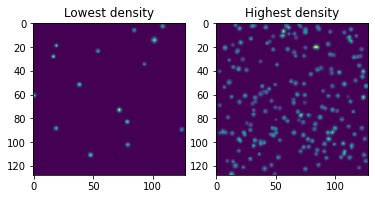

In [9]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sim_spots_all[0][0])
ax[0].set_title('Lowest density')
ax[1].imshow(sim_spots_all[-1][0])
ax[1].set_title('Highest density')

plt.show()

In [10]:
norm_sim_spots_all = np.zeros((len(N_min_list),num_images,L,L,1))

for i in range(np.shape(sim_spots_all)[0]):

    sim_images = [blur_stack[ii] + sim_spots_all[i][ii]*7500 for ii in range(num_images)] 
    norm_sim_images = []
    for image in sim_images:
        min_val = min(map(min,image))
        max_val = max(map(max,image))

        norm_sim_images.append((image-min_val)/(max_val-min_val))

    norm_sim_spots_all[i] = np.array(norm_sim_images)

np.shape(norm_sim_spots_all)

(5, 200, 128, 128, 1)

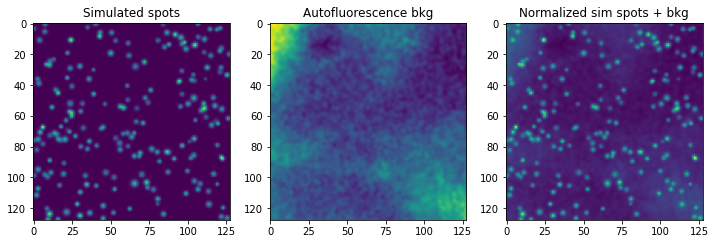

In [11]:
ind=4

fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].imshow(sim_spots_all[2][ind])
ax[0].set_title('Simulated spots')
ax[1].imshow(blur_stack[ind])
ax[1].set_title('Autofluorescence bkg')
ax[2].imshow(norm_sim_spots_all[2][ind])
ax[2].set_title('Normalized sim spots + bkg')

plt.show()

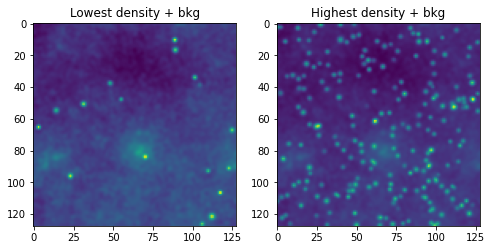

In [12]:
ind=2

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(norm_sim_spots_all[0][ind])
ax[0].set_title('Lowest density + bkg')
ax[1].imshow(norm_sim_spots_all[4][ind])
ax[1].set_title('Highest density + bkg')

plt.show()

In [13]:
snr_list = np.linspace(5000,25000,5)
norm_sim_spots_snr = np.zeros((len(snr_list),num_images,L,L,1))


for i in range(np.shape(norm_sim_spots_snr)[0]):

    sim_images = [blur_stack[ii] + sim_spots_all[2][ii]*snr_list[i] for ii in range(num_images)] 
    norm_sim_images = []
    for image in sim_images:
        min_val = min(map(min,image))
        max_val = max(map(max,image))

        norm_sim_images.append((image-min_val)/(max_val-min_val))

    norm_sim_spots_snr[i] = np.array(norm_sim_images)

np.shape(norm_sim_spots_snr)

(5, 200, 128, 128, 1)

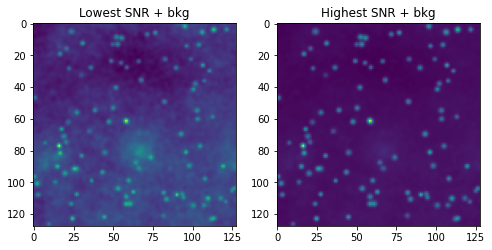

In [14]:
ind=2

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(norm_sim_spots_snr[0][ind])
ax[0].set_title('Lowest SNR + bkg')
ax[1].imshow(norm_sim_spots_snr[4][ind])
ax[1].set_title('Highest SNR + bkg')

plt.show()

# Predict with model trained on simulated data

In a separate notebook, a model has been trained to detect fluorescent spots with simulated spot data at an intermediate density. We load that model to demonstrate its performance on simulate spots of different densities and experimental spot images.

In [15]:
n_epoch = 10  # Number of training epochs
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

sim_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

input_shape: [128, 128, 128]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
sim_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 128, 128, 128 501504      input_1[0][0]                    
__________________________________________________________________________________________________
offset_regression_head (Model)  (None, 128, 128, 2)  2070018     model_4[1][0]                    
__________________________________________________________________________________________________
classification_head (Model)     (None, 128, 128, 2)  17282       model_4[1][0]                    
____________________________________________________________________________________________

In [17]:
sigma=3.0
alpha=0.25
gamma=0.5
focal=False

dotnet_losses = losses.DotNetLosses(sigma=sigma, alpha=alpha, gamma=gamma, focal=focal)

loss = {
    'offset_regression': dotnet_losses.regression_loss,
    'classification': dotnet_losses.classification_loss
}

loss_weights = {"offset_regression": 1.0, "classification": 1.0}
sim_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
# Load model weights
sim_model.load_weights(sim_weights_file[0])

In [19]:
# Predict on simulated images with a range of spot densities
sim_pred_all = np.zeros((len(N_min_list),2,num_images,L,L,2))

for i in range(len(N_min_list)):
    sim_pred_all[i] = sim_model.predict(norm_sim_spots_all[i])

np.shape(sim_pred_all)

(5, 2, 200, 128, 128, 2)

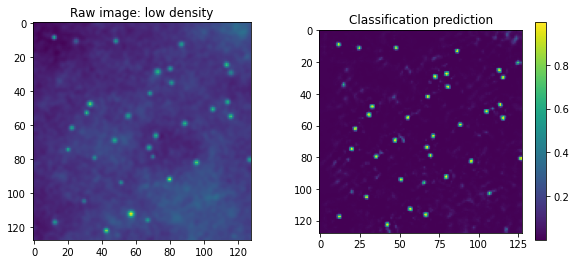

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

density=0
ind=1

ax[0].imshow(norm_sim_spots_all[density][ind])
cp_im = ax[1].imshow(sim_pred_all[density][1][ind,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: low density')
ax[1].set_title('Classification prediction')

plt.show()

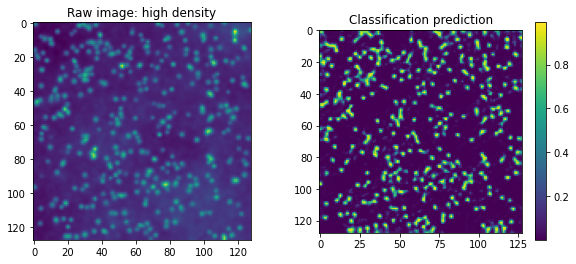

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

density=4
ind=1

ax[0].imshow(norm_sim_spots_all[density][ind])
cp_im = ax[1].imshow(sim_pred_all[density][1][ind,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: high density')
ax[1].set_title('Classification prediction')

plt.show()

The classification prediction shows the probability of a spot in each pixel of the image. We see that the model performs fairly well at predicting the location of spots in simulated images, a separate image set from the one that was used to train the model. However, it predicts spots with low probability in rings around the ground truth spot in images with low spot density and the spots it predicts in high density images do not have a well-defined shape. It would be expected that this model would perform better on simulated images than experimental images, because it was trained with simulated images. 

In [22]:
sim_pred_exp = sim_model.predict(exp_im_stack[:10])

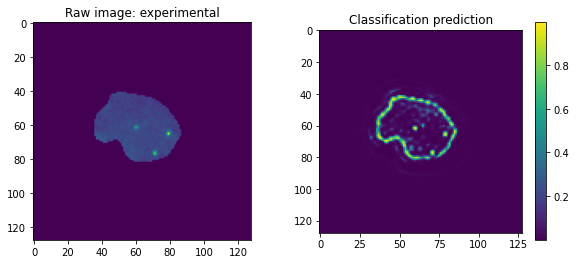

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

ind=0

ax[0].imshow(exp_im_stack[ind])
cp_im = ax[1].imshow(sim_pred_exp[1][ind,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: experimental')
ax[1].set_title('Classification prediction')

plt.show()

In [24]:
sim_pred_exp = sim_model.predict(exp_im_stack[200:210])

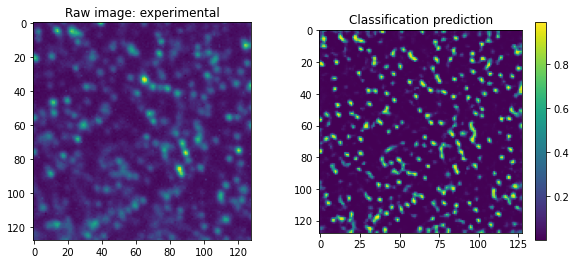

In [25]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

ind=202

ax[0].imshow(exp_im_stack[ind])
cp_im = ax[1].imshow(sim_pred_exp[1][ind-200,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: experimental')
ax[1].set_title('Classification prediction')

plt.show()

We confirm that the model works better for simulated images than experimental images. It predicts a spot in regions of the image where the intensity is changing rapidly, but there is no spot, like in the first example. Also, for example images, like the second, where the spots are more blurred, the model does not output a classification prediction image with well-defined spots. 

# Classical spot detection algorithms

We would expect that a model trained on experimental images, more similar to the above examples, would perform better at predicting the locations of the spots in experimental images. Therefore, we need a method for creating ground truth annotations for experimental images. There are classical spot detection algorithms that can be used to create these annotations. 

In [26]:
from skimage.feature import *

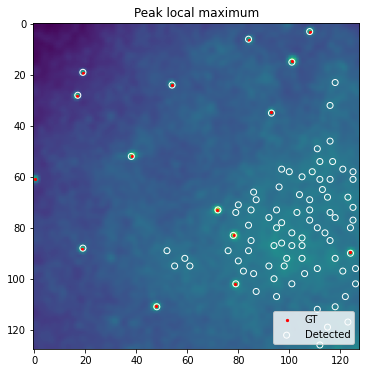

In [27]:
# Peak local maximum
density = 0
ind = 0

ex_plm_coords = peak_local_max(np.squeeze(norm_sim_spots_all[density][ind],axis=-1), threshold_rel=0.4, min_distance=1)

plt.figure(figsize=(6,6))
plt.imshow(norm_sim_spots_all[density][ind])
plt.scatter(coords_all[density][ind][:,1],coords_all[density][ind][:,0],c='r',s=5,label='GT')
plt.scatter(ex_plm_coords[:,1],ex_plm_coords[:,0],facecolors='None',edgecolors='white',label='Detected')
plt.title('Peak local maximum')
plt.legend(loc='lower right')
plt.show()

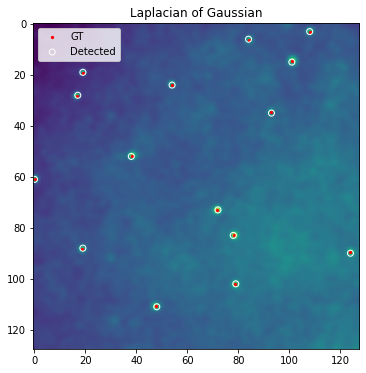

In [28]:
# Laplacian of Gaussian
density = 0
ind = 0

ex_log_coords = blob_log(np.squeeze(norm_sim_spots_all[density][ind],axis=-1), threshold=0.08, min_sigma=1, max_sigma=2)

plt.figure(figsize=(6,6))
plt.imshow(norm_sim_spots_all[density][ind])
plt.scatter(coords_all[density][ind][:,1],coords_all[density][ind][:,0],c='r',s=5,label='GT')
plt.scatter(ex_log_coords[:,1],ex_log_coords[:,0],facecolors='None',edgecolors='white',label='Detected')
plt.title('Laplacian of Gaussian')
plt.legend()
plt.show()

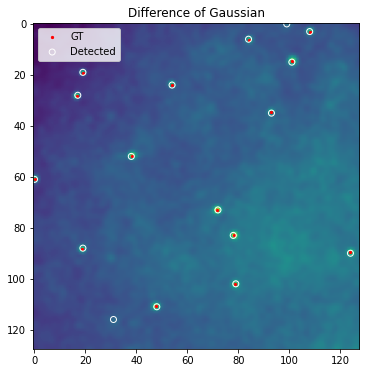

In [29]:
# Laplacian of Gaussian
density = 0
ind = 0

ex_dog_coords = blob_dog(np.squeeze(norm_sim_spots_all[density][ind],axis=-1), threshold=0.03, min_sigma=1, max_sigma=2)

plt.figure(figsize=(6,6))
plt.imshow(norm_sim_spots_all[density][ind])
plt.scatter(coords_all[density][ind][:,1],coords_all[density][ind][:,0],c='r',s=5,label='GT')
plt.scatter(ex_dog_coords[:,1],ex_dog_coords[:,0],facecolors='None',edgecolors='white',label='Detected')
plt.title('Difference of Gaussian')
plt.legend()
plt.show()

The different classical spot detection algorithms, or annotators, each have their own quirks, leading to slightly different annotation outputs. For example, they may differ in how they handle difficult spots, such as those that have a low signal to noise ratio, those close to other spots, and those close to the edge of the image. We would assume that the consensus between the spots is more correct than the annotation sets from any of the individual annotators. Therefore, we need a method to find the consensus between all of the annotation sets from each of the classical spot detection algorithms. 

# Expectation maximization for spot detection

We will use expectation maximization to find the consensus between the annotation sets. This method will use learn the true positive rate and false positive rate for each of the classical annotator and use that information to predict the probability that each detection is a ground turth spot or not. 

In [30]:
import networkx as nx
from scipy.spatial import distance
import matplotlib as mpl

In [31]:
# # Functions for expectation maximization for spot detection
# def define_edges(coords, threshold):
#     """Defines that adjacency matrix for the multiple annotators, connecting points that are sufficiently close to one another
#     It is assumed that these spots are derived from the same ground truth spot in the original image"""
#     all_coords = np.vstack(coords)
#     num_spots = len(all_coords)

#     A = np.zeros((num_spots, num_spots))
#     for i in range(num_spots):
#         for ii in range(i+1, num_spots):
#             dist = np.linalg.norm(all_coords[i] - all_coords[ii])
#             if dist < threshold:
#                 A[i][ii] += 1
#                 A[ii][i] += 1

#     return A

# def label_graph_ann(G, coords):
#     """Labels the annotator associated with each node in the graph"""
#     num_spots = [len(x) for x in coords]

#     # Create list of annotator labels
#     ann_labels = np.array([0]*num_spots[0])
#     for i in range(1,len(num_spots)):
#         temp_labels = np.array([i]*num_spots[i])
#         ann_labels = np.hstack((ann_labels,temp_labels))

#     nodes = list(G.nodes)

#     for i in range(len(nodes)):
#         G.nodes[i]['name'] = ann_labels[i]

#     return G

# def cluster_centroids(G, coords):
#     clusters = list(nx.connected_components(G))
#     flat_coords = np.vstack(coords)

#     centroid_list = []
#     for i in range(len(clusters)):
#         cluster_pts = list(clusters[i])
#         pt_locs = flat_coords[cluster_pts]
#         centroid = [np.mean(pt_locs[:,0]), np.mean(pt_locs[:,1])]
#         centroid_list.append(centroid)

#     return centroid_list

# def jitter(coords,size):
#     result = []
#     for item in coords:
#         noise = np.random.normal(0,size)
#         result.append(item+noise)

#     return result

# def check_spot_ann_num(G, coords):
#     """Check that each annotator only has one spot per cluster, break up clusters that have multiple spots per annotator"""
#     # Get all node labels
#     node_labels = list(nx.get_node_attributes(G,'name').values())
#     # Get all connected nodes = clusters
#     clusters = list(nx.connected_components(G))
#     flat_coords = np.vstack(coords)

#     # Iterate through clusters 
#     for i in range(len(clusters)):
#         # Get points in a cluster
#         cluster_pts = list(clusters[i])

#         # Get labels for points in cluster 
#         pt_labels = np.array(node_labels)[cluster_pts]
        
#         # Check for repeated labels
#         if len(pt_labels) != len(np.unique(pt_labels)):
#             pt_labels = pt_labels.tolist()
#             # Find which labels repeat
#             repeats = set([x for x in pt_labels if pt_labels.count(x) > 1])
#             repeats = list(repeats)
#             # Calculate the centroid of the cluster 
#             pt_locs = flat_coords[cluster_pts]
#             centroid = [np.mean(pt_locs[:,0]), np.mean(pt_locs[:,1])]

#             # Iterate through the repeated clusters 
#             for ii in range(len(repeats)):
#                 # Get points with a particular repeated label
#                 repeat_pts = np.argwhere(np.array(pt_labels) == repeats[ii])
#                 repeat_pts = repeat_pts.tolist()

#                 # Find point that is the closest to the centroid of the cluster 
#                 pt_dists = [distance.euclidean(pt_locs[item],centroid) for item in repeat_pts]
#                 min_ind = np.argmin(pt_dists)

#                 # Remove the point that is the closest to the centroid of the cluster 
#                 repeat_pts.pop(min_ind)

#                 #need to break all edges that have repeating annotators 
#                 for item in repeat_pts:
#                     repeat_node = cluster_pts[item[0]]
#                     edges = list(G.edges(repeat_node))
#                     for edge in edges:
#                         G.remove_edge(*edge)
#     return G

# def ca_matrix(G):
#     """Convert graph into cluster x annotators matrix where 0 mean annotator did not find a point in that cluster
#     and 1 means that the annotator did find a point in that cluster"""
#     clusters = list(nx.connected_components(G))
#     node_labels = list(nx.get_node_attributes(G,'name').values())
#     num_ann = len(np.unique(node_labels))

#     ca_matrix = np.zeros((len(clusters), num_ann))
#     for i in range(len(clusters)):
#         cluster_pts = list(clusters[i])

#         for item in cluster_pts:
#             ca_matrix[i,node_labels[item]] += 1

#     return ca_matrix

# def det_likelihood(cluster_data, pr_list):
#     """Calculate the likelihood that a cluster is a true positive or false positive. To calculate the likelihood of a true positive, pr_list should be a list of TPRs for all annotators. To calculate the likelihood of a cluster being a false positive, pr_list should be a list of FPRs for all annotators. 
    
#     Returns a value for the likelihood that a cluster is either a true positive or a false positive
    
#     Parameters:
#     -----------
#     cluster_data : array_like
#         Array of detection labels for each annotator. Entry has value 1 if annotator detected the cluster, and entry has value 0 if annotator did not detect the cluster. 
#     pr_list : array_like
#         Array of true postive rates for each annotator if one wants to calculate the likelihood that the cluster is a true positive, or array of false positive rates for each annotator if one wants to calculate the likelihood that the cluster is a false positive. 

#     Returns:
#     ---------
#     likelihood : float
#         Value for the likelihood that a cluster is either a true positive or a false positive detection 
    
#     """
#     likelihood = 1

#     for i in range(len(cluster_data)):
#         if cluster_data[i] == 1:
#             likelihood *= pr_list[i]
#         elif cluster_data[i] == 0:
#             likelihood *= (1-pr_list[i])
#     return likelihood

# def norm_marg_likelihood(cluster, tp_list, fp_list, prior):
#     tp_likelihood = det_likelihood(cluster, tp_list)
#     fp_likelihood = det_likelihood(cluster, fp_list)

#     norm_tp_likelihood = tp_likelihood * prior / (tp_likelihood * prior + fp_likelihood * (1-prior))
#     norm_fp_likelihood = fp_likelihood * (1-prior) / (tp_likelihood * prior + fp_likelihood * (1-prior))

#     return norm_tp_likelihood, norm_fp_likelihood

# def em_spot(data, tp_list, fp_list, prior, max_iter=10):
#     """ Estimate the TPR/FPR and probability of true detection for various spot annotators using expectation maximization. 

#     Returns the true positive rate and false positive rate for each annotator, and returns the probability that each spot is a true detection or false detection. 

#     Parameters: 
#     -----------
#     data : matrix
#         Matrix of detection labels for each spot for each annotator. Dimensions spots x annotators. A value of 1 indicates that the spot was detected by that annotator and a value of 0 indicates that the spot was not detected by that annotator. 
#     tp_list : array-like
#         Array of initial guesses for the true positive rates for each annotator. 
#     fp_list : array-like
#         Array of initial guesses for the false positive rates for each annotator. 
#     prior : float
#         Value for the prior probability that a spot is a true positive.
#     max_iter : integer
#         Value for the number of times the expectation maximization algorithm will iteratively calculate the MLE for the TPR and FPR of the annotators.

#     Returns:
#     -----------
#     tp_list : array-like
#         Array of final estimates for the true positive rates for each annotator. 
#     fp_list : array-like
#         Array of final estimates for the false postitive rates for each annotator. 
#     likelihood_matrix : matrix
#         Matrix of probabilities that each cluster is a true detection (column 0) or false detection (column 1). Dimensions spots x 2.
#     """
    
#     likelihood_matrix = np.zeros((len(data), 2))

#     for i in range(max_iter):
#         # Caluclate the probability that each spot is a true detection or false detection
#         likelihood_matrix = np.zeros((len(data), 2))

#         for i in range(len(data)):
#             likelihood_matrix[i] = norm_marg_likelihood(data[i], tp_list, fp_list, prior)

#         # Calculate the expectation value for the number of TP/FN/FP/TN
#         tp_matrix = np.zeros((np.shape(data)))
#         for i in range(len(data)): 
#             tp_matrix[i] = likelihood_matrix[i,0] * data[i]

#         fn_matrix = np.zeros((np.shape(data)))
#         for i in range(len(data)):
#             fn_matrix[i] = likelihood_matrix[i,0] * (data[i] * -1 + 1)

#         fp_matrix = np.zeros((np.shape(data)))
#         for i in range(len(data)):  
#             fp_matrix[i] = likelihood_matrix[i,1] * data[i]

#         tn_matrix = np.zeros((np.shape(data)))
#         for i in range(len(data)):
#             tn_matrix[i] = likelihood_matrix[i,1] * (data[i] * -1 + 1)

#         tp_sum_list = [sum(tp_matrix[:,i]) for i in range(np.shape(data)[1])]
#         fn_sum_list = [sum(fn_matrix[:,i]) for i in range(np.shape(data)[1])]
#         fp_sum_list = [sum(fp_matrix[:,i]) for i in range(np.shape(data)[1])]
#         tn_sum_list = [sum(tn_matrix[:,i]) for i in range(np.shape(data)[1])]

#         # Calculate the MLE estimate for the TPR/FPR
#         tp_list = [tp_sum_list[i] / (tp_sum_list[i]+fn_sum_list[i]) for i in range(np.shape(data)[1])]
#         fp_list = [fp_sum_list[i] / (fp_sum_list[i]+tn_sum_list[i]) for i in range(np.shape(data)[1])]


#     likelihood_matrix = np.round(likelihood_matrix,3)

#     return tp_list, fp_list, likelihood_matrix

# def ca_to_adjacency_matrix(ca_matrix):
#     num_clusters = np.shape(ca_matrix)[0]
#     num_annnotators = np.shape(ca_matrix)[1]
#     tot_det_list = [sum(ca_matrix[:,i]) for i in range(num_annnotators)]
#     tot_num_detections = int(sum(tot_det_list))

#     A = np.zeros((tot_num_detections, tot_num_detections))
#     for i in range(num_clusters):
#         det_list = np.ndarray.flatten(np.argwhere(ca_matrix[i] == 1))
#         combos = list(combinations(det_list, 2))

#         for ii in range(len(combos)):
#             ann_index0 = combos[ii][0]
#             ann_index1 = combos[ii][1]
#             det_index0 = int(sum(tot_det_list[:ann_index0]) + sum(ca_matrix[:i,ann_index0]))
#             det_index1 = int(sum(tot_det_list[:ann_index1]) + sum(ca_matrix[:i,ann_index1]))

#             A[det_index0, det_index1] += 1
#             A[det_index1, det_index0] += 1

#     return A

# def label_graph_annotators(G, data):
#     G_new = G.copy()

#     num_annotators = np.shape(data)[1]

#     num_det = int(sum(data[:,0]))
#     ann_labels = np.array([0]*num_det)
#     for i in range(1,num_annotators):
#         num_det = int(sum(data[:,i]))
#         temp_labels = np.array([i]*num_det)
#         ann_labels = np.hstack((ann_labels,temp_labels))

#     nodes = list(G_new.nodes)

#     for i in range(len(nodes)-1):
#         G_new.nodes[i]['name'] = ann_labels[i]

#     return G_new 

# def label_graph_prob(G, data, p_matrix):
#     G_new = G.copy()

#     num_clusters = np.shape(data)[0]
#     num_annotators = np.shape(data)[1]

#     labels = []
#     for i in range(num_annotators):
#         detections = data[:,i]

#         for ii in range(len(detections)):
#             if detections[ii] == 1:
#                 labels.append(p_matrix[:,0][ii])

#     nodes = list(G.nodes)

#     for i in range(len(nodes)-1):
#         G_new.nodes[i]['name'] = labels[i]
 

#     return G_new

# def make_data_stack(log_coords,dog_coords,plm_coords):
#     # create one annotator data matrix from all images
#     # first iteration out of loop
#     log = log_coords[0]
#     dog = dog_coords[0]
#     plm = plm_coords[0]

#     # cluster all detected spots in first image
#     coords = np.array([plm, log, dog])
#     # adjacency matrix
#     A = define_edges(coords, 2)
#     # create graph
#     G=n.from_numpy_array(A)
#     # label each annotator on graph
#     G_labeled = label_graph_ann(G, coords)
#     # break up clusters with multiple spots from single annotator
#     G_clean = check_spot_ann_num(G_labeled, coords)
#     # calculate centroid of each cluster
#     spot_centroids = cluster_centroids(G, coords)

#     # create annotator data matrix for first image
#     data_stack = ca_matrix(G_clean)
#     ind_skipped = []
#     num_spots_list = [len(data_stack)]
#     centroid_list = [spot_centroids]
#     # iterate through images
#     for i in range(1,len(log_coords)):
#         log = log_coords[i]
#         dog = dog_coords[i]
#         plm = plm_coords[i]

#         if len(log) == 0 or len(dog) == 0 or len(plm) == 0:
#             ind_skipped.append(i)
#             continue

#         coords = np.array([plm, log, dog])
#         A = define_edges(coords, 2)
#         G=nx.from_numpy_array(A)
#         G_labeled = label_graph_ann(G, coords)
#         G_clean = check_spot_ann_num(G_labeled, coords)

#         spot_centroids = cluster_centroids(G, coords)
#         centroid_list.append(spot_centroids)

#         temp_data = ca_matrix(G_clean)
#         num_spots_list.append(len(temp_data))

#         data_stack = np.vstack((data_stack, temp_data))

#     return(data_stack, centroid_list, num_spots_list, ind_skipped)

In [32]:
coords_files = glob.glob(data_dir + 'annotations/*')
coords_files

['/data/20201208-training_data/annotations/20201208-dog_em_output_coords.npy',
 '/data/20201208-training_data/annotations/20201208-log_em_output_coords.npy',
 '/data/20201208-training_data/annotations/20201208-plm_em_output_coords.npy',
 '/data/20201208-training_data/annotations/20201208-em_output_coords.npy']

In [33]:
em_image_files = glob.glob(data_dir + 'images/*')
em_image_files

['/data/20201208-training_data/images/20201208-em_output_images.npy']

In [34]:
dog_coords = np.load(coords_files[0],allow_pickle=True)
log_coords = np.load(coords_files[1],allow_pickle=True)
plm_coords = np.load(coords_files[2],allow_pickle=True)

em_image_stack = np.load(em_image_files[0], allow_pickle=True)

First, we cluster the detections of all of the classical annotators, grouping by detections likely derived from the same ground truth spot. Detections that are closer than some user-defined threshold, currently one pixel, will be clustered together. Then, we check that each cluster has at most one detection from each classical annotator. If there are more than one, only the detection closest to the centroid of the cluster is kept and the others are removed from the cluster.

We then create a matrix with the dimensions (detections x annotators), which has a value of 1 if the annotator detected that particular spot and a value of 0 if the annotator did not detect that spot. We also keep track of the centroids of each cluster for plotting the locations of the clusters with their associated images, the number of spots in each image, and the indices of images without spots, which are skipped. 

In [35]:
data_stack, centroid_list, num_spots_list, ind_skipped = make_data_stack(log_coords,dog_coords,plm_coords)
np.shape(data_stack), np.shape(centroid_list), np.shape(num_spots_list)

((38882, 3), (588,), (588,))

In [36]:
# Running total of the number of spots in each image
running_total_spots = np.zeros(len(num_spots_list)+1)

for i in range(len(num_spots_list)):
    running_total_spots[i+1] = sum(num_spots_list[:i+1])

running_total_spots = running_total_spots.astype(int)

running_total_spots[-1]

38882

In [37]:
image_stack_new = np.delete(em_image_stack, ind_skipped, 0)
plm_coords_new = np.delete(plm_coords, ind_skipped)
log_coords_new = np.delete(log_coords, ind_skipped)
dog_coords_new = np.delete(dog_coords, ind_skipped)
np.shape(image_stack_new)

(588, 128, 128)

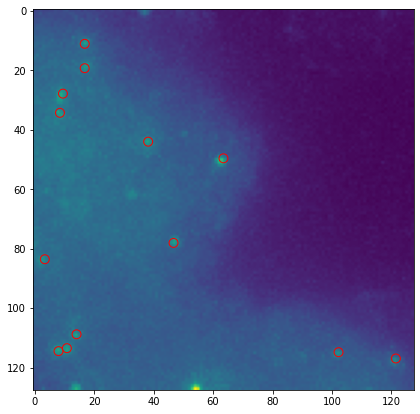

In [38]:
ind=500

plt.figure(figsize=(7,7))
plt.imshow(image_stack_new[ind])
plt.scatter(plm_coords_new[ind][:,1],plm_coords_new[ind][:,0],edgecolors='r',facecolors='None',s=80)
plt.show()

We perform expectation maximization (EM) to learn the TPR and FPR of each of the classical annotators. The prior probability is our guess for the percent of detections that are true detections, based on our intuition of the performance of the classical annotators. We also make an initial guess at the TPR and FPR for each of the annotators. This guess is not informed by any prior analysis, so we make the same guess for each of the annotators. The EM algorithm tends to be robust to this initial guess, so a better guess could be made, but it likely does not matter. 

In [39]:
# em
prior = 0.95

tp_guess = [0.9,0.9,0.9]
fp_guess = [0.1,0.1,0.1]

tp_final_all, fp_final_all, p_matrix_all = em_spot(data_stack, tp_guess, fp_guess, prior, 10)

In [40]:
print('True positive rate for PLM: ' + str(tp_final_all[0]))
print('True positive rate for LoG: ' + str(tp_final_all[1]))
print('True positive rate for DoG: ' + str(tp_final_all[2]))

True positive rate for PLM: 0.7290008409434109
True positive rate for LoG: 0.9511044126056146
True positive rate for DoG: 0.8871503246934347


In [41]:
print('False positive rate for PLM: ' + str(fp_final_all[0]))
print('False positive rate for LoG: ' + str(fp_final_all[1]))
print('False positive rate for DoG: ' + str(fp_final_all[2]))

False positive rate for PLM: 0.9795206393049066
False positive rate for LoG: 0.049292529258076936
False positive rate for DoG: 0.008487380868109845


The output of the EM algorithm matches my expectation for the classical annotators, where PLM performs the worst and LoG and DoG perform better. PLM tends to struggle when the background intensity of the image changes greatly, such as changing intensity of cell autofluorescence, because it uses an absolute intensity threshold to find the spots and does not consider the local intensity neighborhood of a spot. LoG and DoG are better at handling images with changing background intensity. 

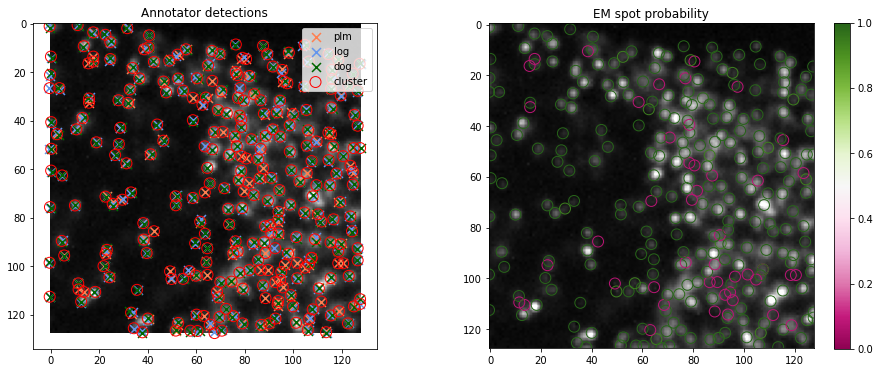

In [42]:
size = 80
jitter_size = 0.3
centroid_list = [np.array(item) for item in centroid_list]
ind =  212
vmax=0.7
cmap = plt.cm.PiYG

fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(image_stack_new[ind],cmap='gray', vmax=vmax)
ax[0].scatter(plm_coords_new[ind][:,1],plm_coords_new[ind][:,0], marker='x', c='coral', s=size, label='plm')
ax[0].scatter(jitter(log_coords_new[ind][:,1],jitter_size),jitter(log_coords_new[ind][:,0],jitter_size), marker='x', c='cornflowerblue', s=size, label='log')
ax[0].scatter(jitter(dog_coords_new[ind][:,1],jitter_size),jitter(dog_coords_new[ind][:,0],jitter_size), marker='x', c='darkgreen', s=size, label='dog')
ax[0].scatter(centroid_list[ind][:,1], centroid_list[ind][:,0], edgecolors='r', facecolors='None', s=120, label='cluster')
ax[0].legend(loc='upper right')
ax[0].set_title('Annotator detections')

running_index = np.arange(running_total_spots[ind], running_total_spots[ind+1])

ax[1].imshow(image_stack_new[ind], cmap='gray',vmax=vmax)
for i in range(len(centroid_list[ind])):
    ax[1].scatter(centroid_list[ind][:,1][i], centroid_list[ind][:,0][i], edgecolors=cmap(p_matrix_all[:,0][running_index[i]]), facecolors='None', s=120, label='cluster')
ax[1].set_title('EM spot probability')


norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap='PiYG', norm=norm)
sm.set_array([])
plt.colorbar(sm)

plt.show()

Plotting the EM output probability of each cluster being a spot over the original image further demonstrates the quality of the EM prediction. We see that the clusters that are rejected by the EM output are mostly portions of the image with high intensity near or between other spots. Therefore, the result of the EM algorithm is more correct than the output of any of the individual classical annotators.

In [43]:
from itertools import combinations

In [44]:
# # Functions for labeling detection clusters
# def ca_to_adjacency_matrix(ca_matrix):
#     num_clusters = np.shape(ca_matrix)[0]
#     num_annnotators = np.shape(ca_matrix)[1]
#     tot_det_list = [sum(ca_matrix[:,i]) for i in range(num_annnotators)]
#     tot_num_detections = int(sum(tot_det_list))

#     A = np.zeros((tot_num_detections, tot_num_detections))
#     for i in range(num_clusters):
#         det_list = np.ndarray.flatten(np.argwhere(ca_matrix[i] == 1))
#         combos = list(combinations(det_list, 2))

#         for ii in range(len(combos)):
#             ann_index0 = combos[ii][0]
#             ann_index1 = combos[ii][1]
#             det_index0 = int(sum(tot_det_list[:ann_index0]) + sum(ca_matrix[:i,ann_index0]))
#             det_index1 = int(sum(tot_det_list[:ann_index1]) + sum(ca_matrix[:i,ann_index1]))

#             A[det_index0, det_index1] += 1
#             A[det_index1, det_index0] += 1

#     return A

# def label_graph_annotators(G, data):
#     G_new = G.copy()

#     num_annotators = np.shape(data)[1]

#     num_det = int(sum(data[:,0]))
#     ann_labels = np.array([0]*num_det)
#     for i in range(1,num_annotators):
#         num_det = int(sum(data[:,i]))
#         temp_labels = np.array([i]*num_det)
#         ann_labels = np.hstack((ann_labels,temp_labels))

#     nodes = list(G_new.nodes)

#     for i in range(len(nodes)-1):
#         G_new.nodes[i]['name'] = ann_labels[i]

#     return G_new 

# def label_graph_prob(G, data, p_matrix):
#     G_new = G.copy()

#     num_clusters = np.shape(data)[0]
#     num_annotators = np.shape(data)[1]

#     labels = []
#     for i in range(num_annotators):
#         detections = data[:,i]

#         for ii in range(len(detections)):
#             if detections[ii] == 1:
#                 labels.append(p_matrix[:,0][ii])

#     nodes = list(G.nodes)

#     for i in range(len(nodes)-1):
#         G_new.nodes[i]['name'] = labels[i]
 

#     return G_new


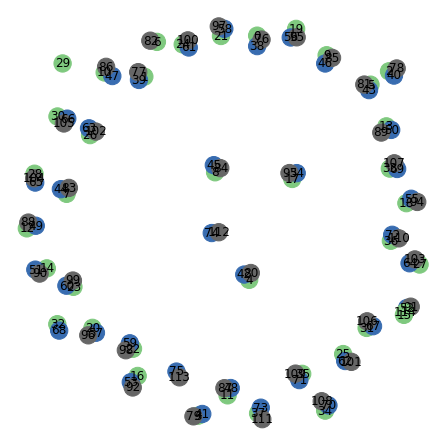

In [45]:
ind=401
data = data_stack[running_total_spots[ind]:running_total_spots[ind+1]]

A = ca_to_adjacency_matrix(data)

G=nx.from_numpy_array(A)

G.add_node(len(G.nodes),pos=(0,0)) 
G.nodes[len(G.nodes)-1]['name'] = 0  

G_labeled = label_graph_annotators(G, data)
pos = nx.spring_layout(G_labeled)

plt.figure(figsize=(6,6))
nx.draw(G_labeled, pos=pos, node_color = list(nx.get_node_attributes(G_labeled,'name').values()), with_labels=True, edge_color='black', cmap=plt.cm.Accent)
# plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Accent))
plt.show()

We can visualize the clusters of annotator detections as a graph. Each of the nodes is a detection, colored by the annotator that made the detection. An edge is drawn between the nodes if the detections are sufficiently close, allowing us to assume that they are derived from the same ground truth spot. 

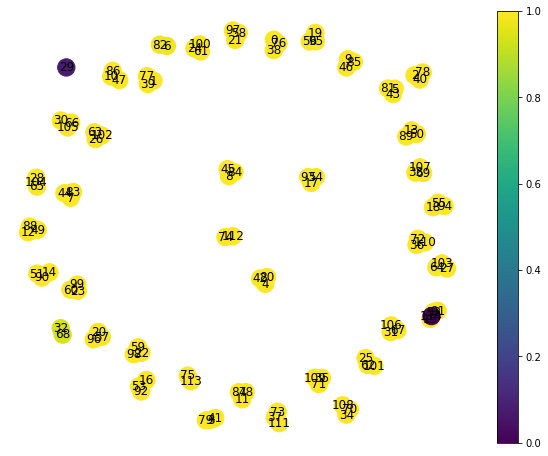

In [46]:
p_matrix = p_matrix_all[running_total_spots[ind]:running_total_spots[ind+1]]

G_labeled = label_graph_prob(G, data, p_matrix)

plt.figure(figsize=(8,6))
nx.draw(G_labeled, pos=pos, node_color = list(nx.get_node_attributes(G_labeled,'name').values()), with_labels=True, edge_color='black', cmap=plt.cm.viridis)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis))
plt.show()

We can color the nodes according to the probability that each cluster is a true detection. We see that the clusters that contain three nodes, meaning that all of the annotators detected the spot, are assigned essentially a 100% probability of being a true detection. The clusters containing two nodes, meaning that one of the annotators did not detect the spot, are assigned a lower probability of being a spot. The clusters with only one node are given a low probability of being a true detection. 

# Benchmarking EM for spot detection 

In order to benchmark the performace of the EM algorithm for spot detection, we need to create simulated cluster data for which we know the grouth truth label, as true detections or false detections. There will be no associated image data with these simulated clusters and we are only simulating the (detections x annotators) data matrix where a value of 1 indicates that an annotator found that cluster and a value of 0 indicates that an annotator did not find a cluster. 

In [47]:
import random 

In [48]:
# def gt_clusters(num_clusters, tp_ratio):
#     """ Generate random simulated labels (true detection or false detection) for clusters, with a specified rate of true detections and false detections, tp_ratio.

#     Returns a list of length num_clusters of cluster labels with value 'T' for a true detection and 'F' for a false detection.

#     Parameters:
#     -----------
#     num_clusters : integer
#         The number of cluster labels to be generated
#     tp_ratio : float
#         The average percentage of the detections that are true detections

#     Returns:
#     ----------
#     gt : list
#         List of random simulated cluster labels 'T' or 'F'

#     """
#     gt = []
#     for i in range(num_clusters):
#         rand = random.random()

#         if rand < tp_ratio:
#             gt.append('T')
#         else:
#             gt.append('F')
#     return gt

# def sim_detection(gt, tpr, fpr):
#     """Simulates detection data for a set of ground truth cluster labels and an annotator with a specified TPR and FPR. 
    
#     Returns an array of with same length as input gt, where 1 indicates the simulated annotator detected a cluster and 0 indicates an undetected cluster.
    
#     Parameters:
#     -------------
#     gt : array-like
#         Array of ground truth cluster labels. 'T' indicates a true detection and 'F' indicates a false detection. 
#     tpr : float
#         The true positive rate of the annotator. For a ground truth value of 'T', it is the probability that the function will output 1, indicating that the simulated annotator detected the true cluster. 
#     fpr : float
#         The false positive rate of the annotator. For a ground truth value of 'F', it is the probability that the funciton will output 1, indicating that the simulated annotator falsely detected the cluster.  
    
#     Returns: 
#     ----------
#     det_list : array-like
#         Array of detected cluster labels. A value of 1 indicates that a cluster was detected by the annotator, and 0 indicates that the cluster was not detected by the annotator. 
#          """
#     det_list = []
#     for item in gt:
#         rand = random.random()
#         if item == 'T':
#             if rand < tpr:
#                 det_list.append(1)
#             else:
#                 det_list.append(0)
#         elif item == 'F':
#             if rand < fpr:
#                 det_list.append(1)
#             else:
#                 det_list.append(0)

#     return det_list

# def sim_data(gt, tpr_list, fpr_list):
#     """Simulate the detections of multiple annotators with different TPRs and FPRs on the same ground truth data. 
    
#     Returns a matrix of simulated detection data with dimensions clusters x annotators. 
    
#     Parameters:
#     ------------
#     gt : array-like
#         Array of ground truth cluster labels. 'T' indicates a true detection and 'F' indicates a false detection. 
#     tpr_list : array-like
#         Array of TPR values for each annotator. For a ground truth value of 'T', the TPR is the probability that the function will output 1, indicating that the simulated annotator detected the true cluster. 
#     fpr_list : array-like
#         Array of FPR values for each annotator. For a ground truth value of 'F', the FPR is the probability that the funciton will output 1, indicating that the simulated annotator falsely detected the cluster.  

#     Returns:
#     --------
#     data_array : matrix
#         Matrix of simulated detection data with dimensions clusters x annotators. A value of 1 indicates a detected clsuter and a value of 0 indicates an undetected cluster. 
#     """

#     data_list = []
#     for i in range(len(tpr_list)):
#         data_list.append(sim_detection(gt, tpr_list[i], fpr_list[i]))

#     data_array = np.array(data_list).T

#     return data_array

# def percent_correct(gt, p_matrix):
#     num_correct = 0

#     for i in range(len(gt)):
#         label = np.round(p_matrix[i,0])

#         if gt[i] == 'T' and label == 1:
#             num_correct += 1
#         elif gt[i] == 'F' and label == 0:
#             num_correct += 1

#     return num_correct / len(gt)

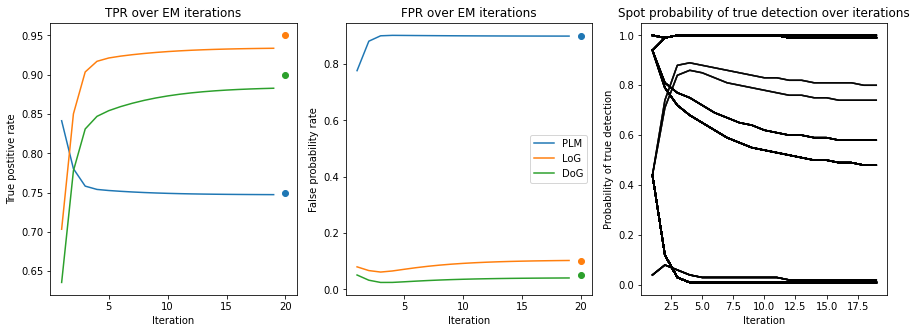

In [49]:
# Convergence of EM output over iterations
prior = 0.5
gt = gt_clusters(5000,prior)

gt_tp_list = [0.75, 0.95, 0.9]
gt_fp_list = [0.9, 0.1, 0.05]
data = sim_data(gt, gt_tp_list, gt_fp_list)

tp_guess = [0.7, 0.7, 0.7]
fp_guess = [0.1, 0.1, 0.1]
prior_guess = 0.5

max_iter = 20
iter_list = np.arange(1,max_iter)

tp_list = []
fp_list = []
p_list = []
for item in iter_list:
    tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior_guess, item)

    tp_list.append(tp_final)
    fp_list.append(fp_final)
    p_list.append(p_matrix)

tp_array = np.array(tp_list)
fp_array = np.array(fp_list)
p_array = np.array(p_list)

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(iter_list,tp_array[:,0])
ax[0].plot(iter_list,tp_array[:,1])
ax[0].plot(iter_list,tp_array[:,2])
ax[0].scatter(max_iter,gt_tp_list[0])
ax[0].scatter(max_iter,gt_tp_list[1])
ax[0].scatter(max_iter,gt_tp_list[2])
ax[0].set_title('TPR over EM iterations')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('True postitive rate')

ax[1].plot(iter_list,fp_array[:,0],label='PLM')
ax[1].plot(iter_list,fp_array[:,1],label='LoG')
ax[1].plot(iter_list,fp_array[:,2],label='DoG')
ax[1].scatter(max_iter,gt_fp_list[0])
ax[1].scatter(max_iter,gt_fp_list[1])
ax[1].scatter(max_iter,gt_fp_list[2])
ax[1].set_title('FPR over EM iterations')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('False probability rate')
ax[1].legend()

# for i in range(np.shape(p_array)[1]):
for i in range(500):
    ax[2].plot(iter_list,p_array[:,i,0], c='k', alpha=0.5)
ax[2].set_title('Spot probability of true detection over iterations')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Probability of true detection')


plt.show()

The output, the TPR, FPR, and the spot probability for each cluster, from the EM algorithm converges over the correct value (the dot in each color). From these results, we know that the EM algorithm is working as expected that we need to exceed at least 15 iterations to know that the EM output has stopped changing over the course of the iterations. 

In [50]:
num_trials = 20
prior_list = np.linspace(0.1,0.9,10)
p_correct_matrix_zero = np.zeros((len(prior_list),num_trials))

correct_list_minus = []
for i in range(len(prior_list)):
    print('Working on prior: ' + str(prior_list[i]))
    for ii in range(num_trials):
        gt = gt_clusters(1000,prior_list[i])

        tp_list = [0.75, 0.95, 0.9]
        fp_list = [0.9, 0.1, 0.001]
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7, 0.7, 0.7]
        fp_guess = [0.1, 0.1, 0.1]

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix_zero[i,ii] = p_correct


Working on prior: 0.1
Working on prior: 0.18888888888888888
Working on prior: 0.2777777777777778
Working on prior: 0.3666666666666667
Working on prior: 0.4555555555555556
Working on prior: 0.5444444444444445
Working on prior: 0.6333333333333333
Working on prior: 0.7222222222222222
Working on prior: 0.8111111111111111
Working on prior: 0.9


In [51]:
num_trials = 20
prior_list = np.linspace(0.1,0.9,10)
p_correct_matrix_plus = np.zeros((len(prior_list),num_trials))

correct_list_minus = []
for i in range(len(prior_list)):
    print('Working on prior: ' + str(prior_list[i]))
    for ii in range(num_trials):
        gt = gt_clusters(1000,prior_list[i])

        tp_list = [0.75, 0.95, 0.9]
        fp_list = [0.9, 0.1, 0.001]
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7, 0.7, 0.7]
        fp_guess = [0.1, 0.1, 0.1]

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior+0.05, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix_plus[i,ii] = p_correct

Working on prior: 0.1
Working on prior: 0.18888888888888888
Working on prior: 0.2777777777777778
Working on prior: 0.3666666666666667
Working on prior: 0.4555555555555556
Working on prior: 0.5444444444444445
Working on prior: 0.6333333333333333
Working on prior: 0.7222222222222222
Working on prior: 0.8111111111111111
Working on prior: 0.9


In [52]:
num_trials = 20
prior_list = np.linspace(0.1,0.9,10)
p_correct_matrix_minus = np.zeros((len(prior_list),num_trials))

correct_list_minus = []
for i in range(len(prior_list)):
    print('Working on prior: ' + str(prior_list[i]))
    for ii in range(num_trials):
        gt = gt_clusters(1000,prior_list[i])

        tp_list = [0.75, 0.95, 0.9]
        fp_list = [0.9, 0.1, 0.001]
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7, 0.7, 0.7]
        fp_guess = [0.1, 0.1, 0.1]

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior-0.05, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix_minus[i,ii] = p_correct

Working on prior: 0.1
Working on prior: 0.18888888888888888
Working on prior: 0.2777777777777778
Working on prior: 0.3666666666666667
Working on prior: 0.4555555555555556
Working on prior: 0.5444444444444445
Working on prior: 0.6333333333333333
Working on prior: 0.7222222222222222
Working on prior: 0.8111111111111111
Working on prior: 0.9


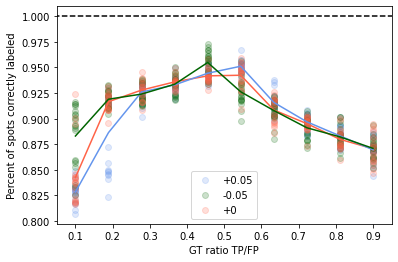

In [53]:
alpha=0.2

mean_plus_list = []
mean_minus_list = []
mean_zero_list = []
for i in range(np.shape(p_correct_matrix_plus)[0]):
    mean_plus_list.append(np.mean(p_correct_matrix_plus[i]))

    if i == 0:
        plt.scatter([prior_list[i]]*num_trials,p_correct_matrix_plus[i],c='cornflowerblue',alpha=alpha,label='+0.05')
    else:
        plt.scatter([prior_list[i]]*num_trials,p_correct_matrix_plus[i],c='cornflowerblue',alpha=alpha)

for i in range(np.shape(p_correct_matrix_minus)[0]):
    mean_minus_list.append(np.mean(p_correct_matrix_minus[i]))

    if i == 0:
        plt.scatter([prior_list[i]]*num_trials,p_correct_matrix_minus[i],c='darkgreen',alpha=alpha,label='-0.05')
    else:
        plt.scatter([prior_list[i]]*num_trials,p_correct_matrix_minus[i],c='darkgreen',alpha=alpha)

for i in range(np.shape(p_correct_matrix_zero)[0]):
    mean_zero_list.append(np.mean(p_correct_matrix_zero[i]))

    if i == 0:
        plt.scatter([prior_list[i]]*num_trials,p_correct_matrix_zero[i],c='tomato',alpha=alpha,label='+0')
    else:
        plt.scatter([prior_list[i]]*num_trials,p_correct_matrix_zero[i],c='tomato',alpha=alpha)

plt.plot(prior_list,mean_zero_list,c='tomato')
plt.plot(prior_list,mean_plus_list,c='cornflowerblue')
plt.plot(prior_list,mean_minus_list,c='darkgreen')

plt.plot([0,1],[1,1],'k--')
plt.xlim((0.05,0.95))
plt.xlabel('GT ratio TP/FP')
plt.ylabel('Percent of spots correctly labeled')
plt.legend()
plt.show()

We can ask how the EM algorithm performs with annotations of varying quality. The quality of the annotations is quantified by the ratio of true detections (TP) to false detections (FP). We can quantify the performance of the EM output by comparing the rounded probability of the EM algorithm to the ground truth labels and calculating the percentage of detections correctly labeled. 

We can also ask how the quality of the prior estimate for the TP/FP ratio determines the quality of the EM algorithm. The percentage of detections correctly labeled are also calculated when the prior estimate for the TP/FP ratio is 0.05 more than the actual ration, 0.05 less, and exactly matching. 

We see that the EM algorithm outputs high quality results for annotations of a broad range of quality, except for very low quality annotations, with a high ratio of false positive detections. However, the annotations from our classical annotators on our experimental data is not expected to have this many false detections, so we can be confident that the quality of the annotations will not have an effect on the accuracy of the EM algorithm. We also know that the quality of the prior does not greatly affect the accuracy of the EM algorithm within the limited range tested. 

In [54]:
num_trials = 20
num_sizes = 8
data_set_size = np.logspace(1,4,num=num_sizes).astype(int)

p_correct_matrix = np.zeros((num_sizes,num_trials))

for i in range(num_sizes):
    print('Working on data set size: ' + str(data_set_size[i]))
    for ii in range(num_trials):
        prior = 0.7
        gt = gt_clusters(data_set_size[i],prior)

        tp_list = [0.75, 0.95, 0.9]
        fp_list = [0.9, 0.1, 0.001]
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7, 0.7, 0.7]
        fp_guess = [0.1, 0.1, 0.1]

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix[i,ii] = p_correct

Working on data set size: 10
Working on data set size: 26
Working on data set size: 71
Working on data set size: 193
Working on data set size: 517
Working on data set size: 1389
Working on data set size: 3727
Working on data set size: 10000


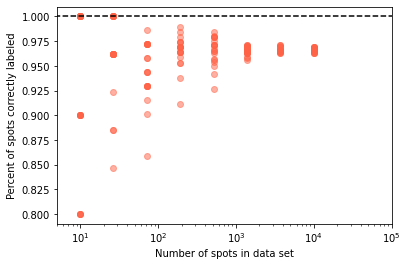

In [55]:
mean_data_size_list = []

for i in range(num_sizes):
    plt.scatter([data_set_size[i]]*num_trials,p_correct_matrix[i],c='tomato',alpha=0.5)
    mean_data_size_list.append(np.mean(p_correct_matrix[i]))

plt.plot([0,10e4],[1,1],'k--')
# plt.plot(data_set_size,mean_data_size_list,'k')
plt.xscale('log')
plt.xlim((5,10e4))
plt.xlabel('Number of spots in data set')
plt.ylabel('Percent of spots correctly labeled')
plt.show()

We can also ask how the quality of the EM output chanes with size of the data set. As expected, the percentage of spot correctly labeled increases with the number of spots in the data set. Importantly, the variance in the percentage of spots correctly labeled decreases. From this analysis, we see that we need data sets that have at least 1000 spots to know that the EM output is reliable. 

In [56]:
num_trials = 20
max_num_annotators = 13

p_correct_matrix = np.zeros((max_num_annotators-2,num_trials))

for i in range(2,max_num_annotators):
    print('Working on annotator number: ' + str(i))
    for ii in range(num_trials):
        prior = 0.7
        gt = gt_clusters(1000,prior)

        tp_list = [0.9]*i
        fp_list = [0.1]*i
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7]*i
        fp_guess = [0.1]*i

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix[i-2,ii] = p_correct

Working on annotator number: 2
Working on annotator number: 3
Working on annotator number: 4
Working on annotator number: 5
Working on annotator number: 6
Working on annotator number: 7
Working on annotator number: 8
Working on annotator number: 9
Working on annotator number: 10
Working on annotator number: 11
Working on annotator number: 12


In [57]:
num_trials = 20
max_num_annotators = 13

p_correct_matrix2 = np.zeros((max_num_annotators-2,num_trials))


for i in range(2,max_num_annotators):
    print('Working on annotator number: ' + str(i))
    for ii in range(num_trials):
        prior = 0.7
        gt = gt_clusters(1000,prior)

        tp_list = np.random.uniform(0.65,0.75,i)
        fp_list = np.random.uniform(0.08,0.12,i)
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7]*i
        fp_guess = [0.1]*i

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix2[i-2,ii] = p_correct

Working on annotator number: 2
Working on annotator number: 3
Working on annotator number: 4
Working on annotator number: 5
Working on annotator number: 6
Working on annotator number: 7
Working on annotator number: 8
Working on annotator number: 9
Working on annotator number: 10
Working on annotator number: 11
Working on annotator number: 12


In [58]:
num_trials = 20
max_num_annotators = 13

p_correct_matrix3 = np.zeros((max_num_annotators-2,num_trials))


for i in range(2,max_num_annotators):
    print('Working on annotator number: ' + str(i))
    for ii in range(num_trials):
        prior = 0.7
        gt = gt_clusters(1000,prior)

        tp_list = np.random.uniform(0.5,0.9,i)
        fp_list = np.random.uniform(0.01,0.19,i)
        data = sim_data(gt, tp_list, fp_list)

        tp_guess = [0.7]*i
        fp_guess = [0.1]*i

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)

        p_correct_matrix3[i-2,ii] = p_correct

Working on annotator number: 2
Working on annotator number: 3
Working on annotator number: 4
Working on annotator number: 5
Working on annotator number: 6
Working on annotator number: 7
Working on annotator number: 8
Working on annotator number: 9
Working on annotator number: 10
Working on annotator number: 11
Working on annotator number: 12


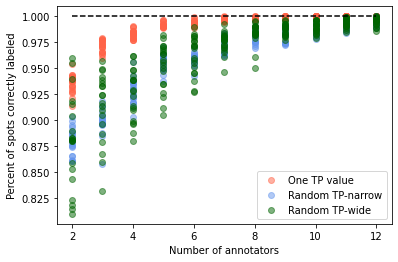

In [59]:
for i in range(np.shape(p_correct_matrix)[0]):
    if i == 0:
        plt.scatter([i+2]*num_trials,p_correct_matrix[i],c='tomato',alpha=0.5,label='One TP value')
    else:
        plt.scatter([i+2]*num_trials,p_correct_matrix[i],c='tomato',alpha=0.5)

for i in range(np.shape(p_correct_matrix2)[0]):
    if i == 0:
        plt.scatter([i+2]*num_trials,p_correct_matrix2[i],c='cornflowerblue',alpha=0.5,label='Random TP-narrow')
    else:
        plt.scatter([i+2]*num_trials,p_correct_matrix2[i],c='cornflowerblue',alpha=0.5)

for i in range(np.shape(p_correct_matrix3)[0]):
    if i == 0:
        plt.scatter([i+2]*num_trials,p_correct_matrix3[i],c='darkgreen',alpha=0.5,label='Random TP-wide')
    else:
        plt.scatter([i+2]*num_trials,p_correct_matrix3[i],c='darkgreen',alpha=0.5)

plt.plot([2,12],[1,1],'k--')
plt.xlabel('Number of annotators')
plt.ylabel('Percent of spots correctly labeled')
plt.legend()
plt.show()

We can also ask how the quality of the EM output changes with the number of annotators used to analyze the detections. As expected, we see that the average percent of detections correctly labeled and the variance of this value increases as the number of annotators increases. From this analysis, we see that the accuracy of the EM increases faster if the quality of the annotators is more consistent and generally, the EM output is better with at least 5 annotators of consistent quality and more if the annotators are inconsistent in quality. 

# Training a deep learning model for spot detection with EM results

Now that we know that the EM algorithm outputs accurate estimates for the probability of a spot being a true detection, we can use it to learn the consensus between the annotations made by different classical annotators on experimental FISH images. An example of this method is shown previously in this notebook. The consensus annotations were used to train a deep learning model for spot detection in a separate notebook. 

In [60]:
n_epoch = 10  # Number of training epochs
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

em_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

input_shape: [128, 128, 128]


In [61]:
em_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 128, 128, 128 501504      input_9[0][0]                    
__________________________________________________________________________________________________
offset_regression_head (Model)  (None, 128, 128, 2)  2070018     model_10[1][0]                   
__________________________________________________________________________________________________
classification_head (Model)     (None, 128, 128, 2)  17282       model_10[1][0]                   
___________________________________________________________________________________________

In [62]:
sigma=3.0
alpha=0.25
gamma=0.5
focal=False

dotnet_losses = losses.DotNetLosses(sigma=sigma, alpha=alpha, gamma=gamma, focal=focal)

loss = {
    'offset_regression': dotnet_losses.regression_loss,
    'classification': dotnet_losses.classification_loss
}

loss_weights = {"offset_regression": 1.0, "classification": 1.0}
em_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])

In [63]:
# Load model weights
em_model.load_weights(em_weights_file[0])

In [64]:
# Predict on simulated images with a range of spot densities
em_pred_all = np.zeros((len(N_min_list),2,num_images,L,L,2))

for i in range(len(N_min_list)):
    em_pred_all[i] = em_model.predict(norm_sim_spots_all[i])

np.shape(em_pred_all)

(5, 2, 200, 128, 128, 2)

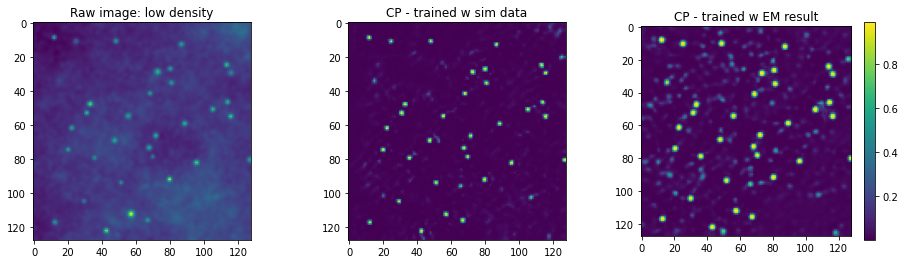

In [65]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

density=0
ind=1

ax[0].imshow(norm_sim_spots_all[density][ind])
ax[1].imshow(sim_pred_all[density][1][ind,:,:,1])
cp_im = ax[2].imshow(em_pred_all[density][1][ind,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: low density')
ax[1].set_title('CP - trained w sim data')
ax[2].set_title('CP - trained w EM result')

plt.show()

We can compare the classification prediction (CP) for each of the models - trained on simulated data and trained on the EM result - for the same simulated image. We can see that the model trained on the EM result has a cleaner prediction for the location of the spots. The EM model was trained on consensus annotations from experimental data and yields a more robust prediction for the location of the spots, despite the model trained on simulated data was trained on data that is essentially equivalent to the test image set. 

In [66]:
sim_pred_exp = sim_model.predict(exp_im_stack[:10])
em_pred_exp = em_model.predict(exp_im_stack[:10])

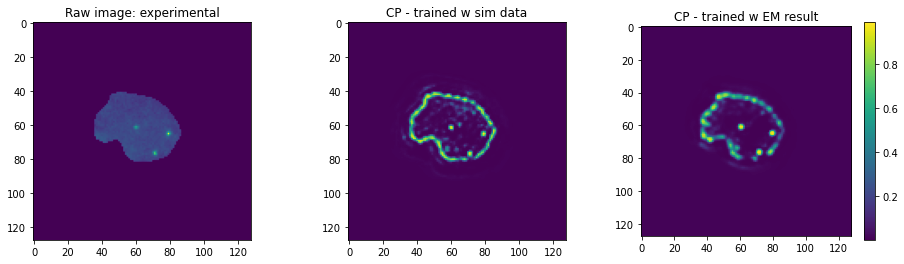

In [67]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ind=0

ax[0].imshow(exp_im_stack[ind])
ax[1].imshow(sim_pred_exp[1][ind,:,:,1])
cp_im = ax[2].imshow(em_pred_exp[1][ind,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: experimental')
ax[1].set_title('CP - trained w sim data')
ax[2].set_title('CP - trained w EM result')

plt.show()

We see that the model trained on the EM result, similarly to the model trained on the simulated data, does handle sharp changes in pixel intensity well. This must be considered if portions of the image, like the cell nucleus in this example, are masked out, creating a sharp boundary in the image. 

In [68]:
sim_pred_exp = sim_model.predict(exp_im_stack[200:210])
em_pred_exp = em_model.predict(exp_im_stack[200:210])

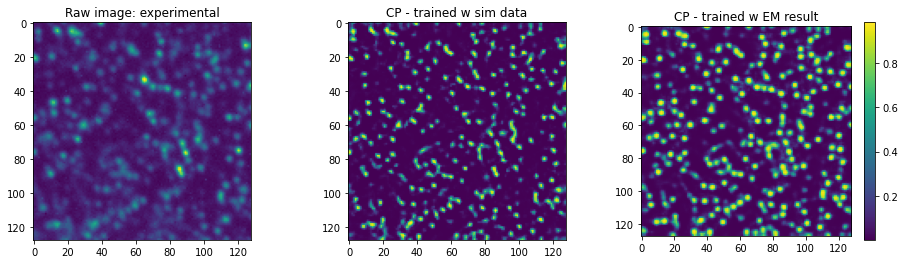

In [69]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ind=202

ax[0].imshow(exp_im_stack[ind])
ax[1].imshow(sim_pred_exp[1][ind-200,:,:,1])
cp_im = ax[2].imshow(em_pred_exp[1][ind-200,:,:,1])
fig.colorbar(cp_im)

ax[0].set_title('Raw image: experimental')
ax[1].set_title('CP - trained w sim data')
ax[2].set_title('CP - trained w EM result')

plt.show()

We see that the model trained with the EM result yield classification prediction images with predicted spots that have a much more clearly defined shape that the model trained on simulated data. However, we want to be able to quantitatively benchmark the performace of these models, so we need to convert the classification prediction image into a list of spot locations, which can be directly compared to the list of ground truth spot locations. 

# Benchmarking the deep learning models for spot detection 

In [70]:
# def y_annotations_to_point_list(y_pred, ind, threshold):
#     """ Convert raw prediction to a predicted point list
    
#     Args:
#     y_pred: a batch of predictions, of the format: y_pred[annot_type][ind] is an annotation for image #ind in the batch
#     where annot_type = 0 or 1: 0 - contains_dot, 1 - offset matrices
    
#     ind: the index of the image in the batch for which to convert the annotations
    
#     threshold: a number in [0, 1]. Pixels with classification score > threshold are considered containing a spot center,
#     and their corresponding regression values will be used to create a final spot position prediction which will
#     be added to the output spot center coordinates list.
    
#     Returns:
#     A list of spot center coordinates of the format [[y0, x0], [y1, x1],...]
#     """

#     contains_dot = y_pred[1][ind,...,1] > threshold
#     delta_y = y_pred[0][ind,...,0]
#     delta_x = y_pred[0][ind,...,1]

#     dot_pixel_inds = np.argwhere(contains_dot)
#     dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
#     return dot_centers

# def y_annotations_to_point_list2(y_pred, ind, threshold):
#     # make final decision to be: classification of pixel as containing dot > threshold AND
#     # center regression is contained in the pixel
#     contains_dot = y_pred[1][ind,...,1] > threshold
#     delta_y = y_pred[0][ind,...,0]
#     delta_x = y_pred[0][ind,...,1]
#     contains_its_regression = (abs(delta_x)<=0.5) & (abs(delta_y)<=0.5)
    
#     final_dot_detection = contains_dot & contains_its_regression

#     dot_pixel_inds = np.argwhere(final_dot_detection)
#     dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
#     return dot_centers

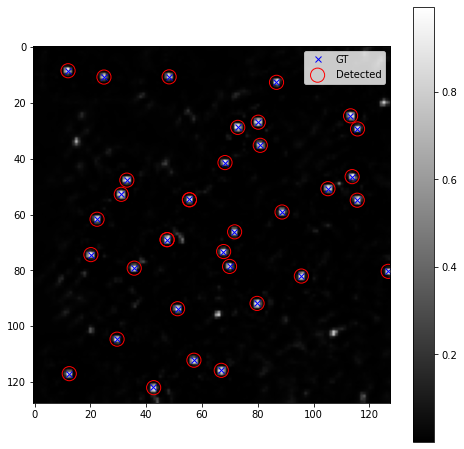

In [71]:
density=0
ind = 1
vmax=None
threshold=0.9
points_list2 = y_annotations_to_point_list2(sim_pred_all[density], ind, threshold)

plt.figure(figsize=(8,8))
# plt.imshow(sim_stack[ind,...,0],vmax=vmax,cmap='gray')
plt.imshow(sim_pred_all[density][1][ind,:,:,1],cmap='gray')
plt.colorbar()
plt.scatter(points_list2[:,1], points_list2[:,0],edgecolors='r', facecolors='None',s=200,label='Detected')
plt.plot(coords_all[density][ind][:,1],coords_all[density][ind][:,0],'xb',label='GT')
plt.legend()
plt.show()

The above function is highly effective at converting the classification prediction into a list of spot locations. It first thresholds the classification prediction, masking out the pixels with a probability above some threshold of containing a spot. Then this masked image is compared against the regression image, which quantifies each pixel's distance from the nearest predicted spot. The pixels where the nearest spot is closer than 0.5 pixels are masked out, leaving only the pixels that are at the center of each spot. Then, the pixels where both conditions are met, where the classification prediction is above some value and a spot is predicted to have its center, are kept and reported as a spot. The threshold for the classification prediction image can be tuned by the user. 

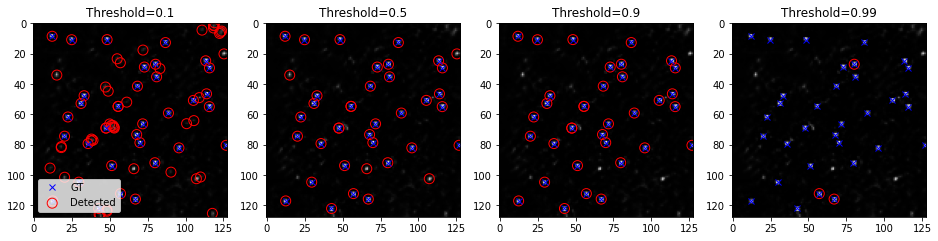

In [72]:
density=0
ind = 1
vmax=None
threshold=[0.1,0.5,0.9,0.99]

fig,ax=plt.subplots(1,4,figsize=(16,6))


for i in range(len(threshold)):
    points_list2 = y_annotations_to_point_list2(sim_pred_all[density], ind, threshold[i])
    
    ax[i].imshow(sim_pred_all[density][1][ind,:,:,1],cmap='gray')
    ax[i].scatter(points_list2[:,1], points_list2[:,0],edgecolors='r', facecolors='None',s=100,label='Detected')
    ax[i].plot(coords_all[density][ind][:,1],coords_all[density][ind][:,0],'xb',label='GT')
    ax[i].set_title('Threshold='+str(np.round(threshold[i],2)))
    if i == 0:
        ax[i].legend(loc='lower left')
        
plt.show()

We can see that, when the threshold is set too low, there are many objects that are predicted to be spots that do not correspond with ground truth spots and when the threshold is set too high, there are objects that are not predicted to be spots that correspond with ground truth spots. 

In [73]:
threshold=0.9
density=0
ind=0

points_list2 = y_annotations_to_point_list2(sim_pred_all[density], ind, threshold)
stats_points(coords_all[density][ind],points_list2,0.9)

{'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'JAC': 1.0,
 'RMSE': 0.08345057124846518,
 'd_md': 0.07447611985009668}

For each image, we can calculate the metrics for comparing the ground truth spot locations to the locations of the detected spots. These metrics include precision, recall, F1 score, and Jacard index, quantifying how many of the spots were detected or missed by the spot detection deep learning model. The metrics, RMSE and sum mean distance (d_md), quantify the localization error of the points list output by the deep learning model.  We will use these metrics to compare the performance of deep learning models trained with different sets of annotations. 

In [74]:
# Models trained on each of the individual annotators
plm_weights_file = glob.glob(model_dir + '*plm.h5')
log_weights_file = glob.glob(model_dir + '*log.h5')
dog_weights_file = glob.glob(model_dir + '*dog.h5')

In [75]:
plm_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

plm_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
plm_model.load_weights(plm_weights_file[0])

input_shape: [128, 128, 128]


In [76]:
# Predict on simulated images with a range of spot densities
plm_pred_all = np.zeros((len(N_min_list),2,num_images,L,L,2))

for i in range(len(N_min_list)):
    plm_pred_all[i] = plm_model.predict(norm_sim_spots_all[i])

np.shape(plm_pred_all)

(5, 2, 200, 128, 128, 2)

In [77]:
log_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

log_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
log_model.load_weights(log_weights_file[0])

input_shape: [128, 128, 128]


In [78]:
# Predict on simulated images with a range of spot densities
log_pred_all = np.zeros((len(N_min_list),2,num_images,L,L,2))

for i in range(len(N_min_list)):
    log_pred_all[i] = log_model.predict(norm_sim_spots_all[i])

np.shape(log_pred_all)

(5, 2, 200, 128, 128, 2)

In [79]:
dog_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

dog_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
dog_model.load_weights(dog_weights_file[0])

input_shape: [128, 128, 128]


In [80]:
# Predict on simulated images with a range of spot densities
dog_pred_all = np.zeros((len(N_min_list),2,num_images,L,L,2))

for i in range(len(N_min_list)):
    dog_pred_all[i] = dog_model.predict(norm_sim_spots_all[i])

np.shape(dog_pred_all)

(5, 2, 200, 128, 128, 2)

In [81]:
# def cp_benchmarking(pred,images,coords,threshold):
#     precision = []
#     recall = []
#     f1 = []
#     jac = []
#     rmse = []
#     dmd = []

#     for i in range(len(images)):
#         points_list2 = y_annotations_to_point_list2(pred, i, threshold)
#         stats_dict = stats_points(coords[i],points_list2,0.9)
#         precision.append(stats_dict['precision'])
#         recall.append(stats_dict['recall'])
#         f1.append(stats_dict['F1'])
#         jac.append(stats_dict['JAC'])
#         rmse.append(stats_dict['RMSE'])
#         dmd.append(stats_dict['d_md'])
        
#     return(precision,recall,f1,jac,rmse,dmd)

In [82]:
density = 2
threshold=0.95

sim_prec,sim_recall,sim_f1,sim_jac,sim_rmse,sim_dmd = cp_benchmarking(sim_pred_all[density],norm_sim_spots_all[density],coords_all[density],threshold)

print('Mean precision of sim. model: '+str(np.mean(sim_prec)))
print('Mean recall of sim. model: '+str(np.mean(sim_recall)))
print('Mean F1 score of sim. model: '+str(np.mean(sim_f1)))

Mean precision of sim. model: 0.9103533846305447
Mean recall of sim. model: 0.5881816264960968
Mean F1 score of sim. model: 0.7045053811944711


We calculate benchmarking statistics for all of the models at an intermediate dot density with a high threshold of 0.95.

In [83]:
em_prec,em_recall,em_f1,em_jac,em_rmse,em_dmd = cp_benchmarking(em_pred_all[density],norm_sim_spots_all[density],coords_all[density],threshold)
plm_prec,plm_recall,plm_f1,plm_jac,plm_rmse,plm_dmd = cp_benchmarking(plm_pred_all[density],norm_sim_spots_all[density],coords_all[density],threshold)
log_prec,log_recall,log_f1,log_jac,log_rmse,log_dmd = cp_benchmarking(log_pred_all[density],norm_sim_spots_all[density],coords_all[density],threshold)
dog_prec,dog_recall,dog_f1,dog_jac,dog_rmse,dog_dmd = cp_benchmarking(dog_pred_all[density],norm_sim_spots_all[density],coords_all[density],threshold)

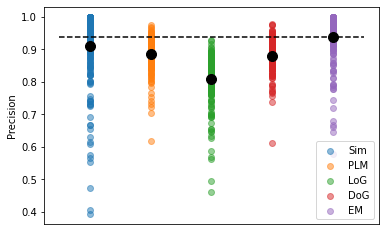

In [84]:
alpha=0.5

plt.scatter([1]*len(norm_sim_spots_all[density]),sim_prec,alpha=alpha,label='Sim')
plt.scatter([1], np.mean(sim_prec),c='k',s=100)

plt.scatter([2]*len(norm_sim_spots_all[density]),plm_prec,alpha=alpha,label='PLM')
plt.scatter([2], np.mean(plm_prec),c='k',s=100)

plt.scatter([3]*len(norm_sim_spots_all[density]),log_prec,alpha=alpha,label='LoG')
plt.scatter([3], np.mean(log_prec),c='k',s=100)

plt.scatter([4]*len(norm_sim_spots_all[density]),dog_prec,alpha=alpha,label='DoG')
plt.scatter([4], np.mean(dog_prec),c='k',s=100)

plt.scatter([5]*len(norm_sim_spots_all[density]),em_prec,alpha=alpha,label='EM')
plt.scatter([5], np.mean(em_prec),c='k',s=100)
plt.plot([0.5,5.5], [np.mean(em_prec)]*2,'--k')

plt.xticks([])
plt.ylabel('Precision')
plt.legend()
plt.show()

Each point is the precision calculated for a single image. The black dot is the average precision for each annotator. The black dashed line is the average value for the precision of the model trained with the EM output. We can see that the model trained with the EM output has the highest precision out of all of the models. We would expect the model trained on simulated data to perform well predicting the locations of spot in more simulated images, so its high precision is not surprising. 

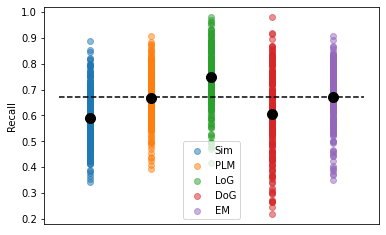

In [85]:
alpha=0.5

plt.scatter([1]*len(norm_sim_spots_all[density]),sim_recall,alpha=alpha,label='Sim')
plt.scatter([1], np.mean(sim_recall),c='k',s=100)

plt.scatter([2]*len(norm_sim_spots_all[density]),plm_recall,alpha=alpha,label='PLM')
plt.scatter([2], np.mean(plm_recall),c='k',s=100)

plt.scatter([3]*len(norm_sim_spots_all[density]),log_recall,alpha=alpha,label='LoG')
plt.scatter([3], np.mean(log_recall),c='k',s=100)

plt.scatter([4]*len(norm_sim_spots_all[density]),dog_recall,alpha=alpha,label='DoG')
plt.scatter([4], np.mean(dog_recall),c='k',s=100)

plt.scatter([5]*len(norm_sim_spots_all[density]),em_recall,alpha=alpha,label='EM')
plt.scatter([5], np.mean(em_recall),c='k',s=100)
plt.plot([0.5,5.5], [np.mean(em_recall)]*2,'--k')

plt.xticks([])
plt.ylabel('Recall')
plt.legend()
plt.show()

However, we see that the model trained on with the EM output has the lowest recall out of all of the models. 

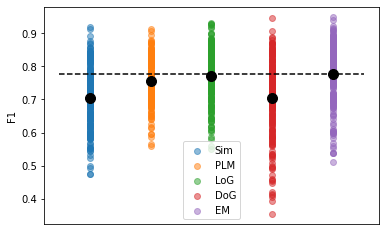

In [86]:
alpha=0.5

plt.scatter([1]*len(norm_sim_spots_all[density]),sim_f1,alpha=alpha,label='Sim')
plt.scatter([1], np.mean(sim_f1),c='k',s=100)

plt.scatter([2]*len(norm_sim_spots_all[density]),plm_f1,alpha=alpha,label='PLM')
plt.scatter([2], np.mean(plm_f1),c='k',s=100)

plt.scatter([3]*len(norm_sim_spots_all[density]),log_f1,alpha=alpha,label='LoG')
plt.scatter([3], np.mean(log_f1),c='k',s=100)

plt.scatter([4]*len(norm_sim_spots_all[density]),dog_f1,alpha=alpha,label='DoG')
plt.scatter([4], np.mean(dog_f1),c='k',s=100)

plt.scatter([5]*len(norm_sim_spots_all[density]),em_f1,alpha=alpha,label='EM')
plt.scatter([5], np.mean(em_f1),c='k',s=100)
plt.plot([0.5,5.5], [np.mean(em_f1)]*2,'--k')

plt.xticks([])
plt.ylabel('F1')
plt.legend()
plt.show()

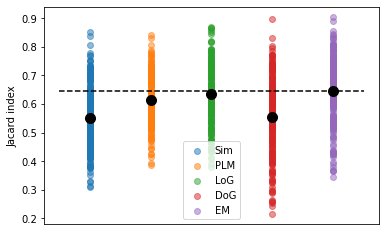

In [87]:
alpha=0.5

plt.scatter([1]*len(norm_sim_spots_all[density]),sim_jac,alpha=alpha,label='Sim')
plt.scatter([1], np.mean(sim_jac),c='k',s=100)

plt.scatter([2]*len(norm_sim_spots_all[density]),plm_jac,alpha=alpha,label='PLM')
plt.scatter([2], np.mean(plm_jac),c='k',s=100)

plt.scatter([3]*len(norm_sim_spots_all[density]),log_jac,alpha=alpha,label='LoG')
plt.scatter([3], np.mean(log_jac),c='k',s=100)

plt.scatter([4]*len(norm_sim_spots_all[density]),dog_jac,alpha=alpha,label='DoG')
plt.scatter([4], np.mean(dog_jac),c='k',s=100)

plt.scatter([5]*len(norm_sim_spots_all[density]),em_jac,alpha=alpha,label='EM')
plt.scatter([5], np.mean(em_jac),c='k',s=100)
plt.plot([0.5,5.5], [np.mean(em_jac)]*2,'--k')

plt.xticks([])
plt.ylabel('Jacard index')
plt.legend()
plt.show()

In [88]:
num_spots = np.zeros((len(N_min_list),num_images))

for i in range(len(N_min_list)):
    num_spots[i] = np.array([len(item) for item in coords_all[i]])

In [89]:
threshold=0.95
ind=0

prec_all_sim = []
recall_all_sim = []
f1_all_sim = []
error_all_sim = []

for density in range(len(N_min_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(sim_pred_all[density], ind, threshold)
        stats_dict = stats_points(coords_all[density][ind],points_list2,threshold)
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_all_sim.append(prec)
    recall_all_sim.append(recall)
    f1_all_sim.append(f1)
    error_all_sim.append(error)
    

prec_all_sim = np.array(prec_all_sim)
recall_all_sim = np.array(recall_all_sim)
f1_all_sim = np.array(f1_all_sim)
error_all_sim = np.array(error_all_sim)

In [90]:
threshold=0.95
ind=0

prec_all_plm = []
recall_all_plm = []
f1_all_plm = []
error_all_plm = []

for density in range(len(N_min_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(plm_pred_all[density], ind, threshold)
        stats_dict = stats_points(coords_all[density][ind],points_list2,threshold)
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_all_plm.append(prec)
    recall_all_plm.append(recall)
    f1_all_plm.append(f1)
    error_all_plm.append(error)
    

prec_all_plm = np.array(prec_all_plm)
recall_all_plm = np.array(recall_all_plm)
f1_all_plm = np.array(f1_all_plm)
error_all_plm = np.array(error_all_plm)

In [91]:
threshold=0.95
ind=0

prec_all_em = []
recall_all_em = []
f1_all_em = []
error_all_em = []

for density in range(len(N_min_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(em_pred_all[density], ind, threshold)
        stats_dict = stats_points(coords_all[density][ind],points_list2,threshold)
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_all_em.append(prec)
    recall_all_em.append(recall)
    f1_all_em.append(f1)
    error_all_em.append(error)
    

prec_all_em = np.array(prec_all_em)
recall_all_em = np.array(recall_all_em)
f1_all_em = np.array(f1_all_em)
error_all_em = np.array(error_all_em)

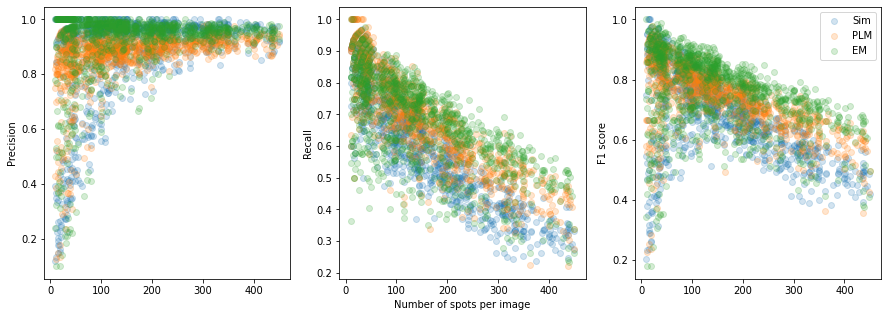

In [92]:
alpha = 0.2

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(num_spots,prec_all_sim,alpha=alpha,label='Sim')
ax[0].scatter(num_spots,prec_all_plm,alpha=alpha,label='PLM')
ax[0].scatter(num_spots,prec_all_em,alpha=alpha,label='EM')

ax[1].scatter(num_spots,recall_all_sim,alpha=alpha,label='Sim')
ax[1].scatter(num_spots,recall_all_plm,alpha=alpha,label='PLM')
ax[1].scatter(num_spots,recall_all_em,alpha=alpha,label='EM')

ax[2].scatter(num_spots,f1_all_sim,alpha=alpha,label='Sim')
ax[2].scatter(num_spots,f1_all_plm,alpha=alpha,label='PLM')
ax[2].scatter(num_spots,f1_all_em,alpha=alpha,label='EM')

plt.legend()
ax[1].set_xlabel('Number of spots per image')
ax[0].set_ylabel('Precision')
ax[1].set_ylabel('Recall')
ax[2].set_ylabel('F1 score')
plt.show()

In [93]:
# Predict on simulated images with a range of spot intensities (SNR)
sim_pred_snr = np.zeros((len(N_min_list),2,num_images,L,L,2))
plm_pred_snr = np.zeros((len(N_min_list),2,num_images,L,L,2))
log_pred_snr = np.zeros((len(N_min_list),2,num_images,L,L,2))
dog_pred_snr = np.zeros((len(N_min_list),2,num_images,L,L,2))
em_pred_snr = np.zeros((len(N_min_list),2,num_images,L,L,2))

for i in range(len(N_min_list)):
    sim_pred_snr[i] = sim_model.predict(norm_sim_spots_snr[i])
    plm_pred_snr[i] = plm_model.predict(norm_sim_spots_snr[i])
    log_pred_snr[i] = log_model.predict(norm_sim_spots_snr[i])
    dog_pred_snr[i] = dog_model.predict(norm_sim_spots_snr[i])
    em_pred_snr[i] = em_model.predict(norm_sim_spots_snr[i])

np.shape(dog_pred_snr)

(5, 2, 200, 128, 128, 2)

In [94]:
threshold=0.95
ind=0

prec_snr_sim = []
recall_snr_sim = []
f1_snr_sim = []
error_snr_sim = []

for density in range(len(snr_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(sim_pred_snr[density], ind, threshold)
        stats_dict = stats_points(coords_all[2][ind],points_list2,threshold)
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_snr_sim.append(prec)
    recall_snr_sim.append(recall)
    f1_snr_sim.append(f1)
    error_snr_sim.append(error)
    

prec_snr_sim = np.array(prec_snr_sim)
recall_snr_sim = np.array(recall_snr_sim)
f1_snr_sim = np.array(f1_snr_sim)
error_snr_sim = np.array(error_snr_sim)

In [95]:
threshold=0.95
ind=0

prec_snr_plm = []
recall_snr_plm = []
f1_snr_plm = []
error_snr_plm = []

for density in range(len(snr_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(plm_pred_snr[density], ind, threshold)
        stats_dict = stats_points(coords_all[2][ind],points_list2,threshold)
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_snr_plm.append(prec)
    recall_snr_plm.append(recall)
    f1_snr_plm.append(f1)
    error_snr_plm.append(error)
    

prec_snr_plm = np.array(prec_snr_plm)
recall_snr_plm = np.array(recall_snr_plm)
f1_snr_plm = np.array(f1_snr_plm)
error_snr_plm = np.array(error_snr_plm)

In [96]:
threshold=0.95
ind=0

prec_snr_em = []
recall_snr_em = []
f1_snr_em = []
error_snr_em = []

for density in range(len(snr_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(em_pred_snr[density], ind, threshold)
        stats_dict = stats_points(coords_all[2][ind],points_list2,threshold)
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_snr_em.append(prec)
    recall_snr_em.append(recall)
    f1_snr_em.append(f1)
    error_snr_em.append(error)
    

prec_snr_em = np.array(prec_snr_em)
recall_snr_em = np.array(recall_snr_em)
f1_snr_em = np.array(f1_snr_em)
error_snr_em = np.array(error_snr_em)

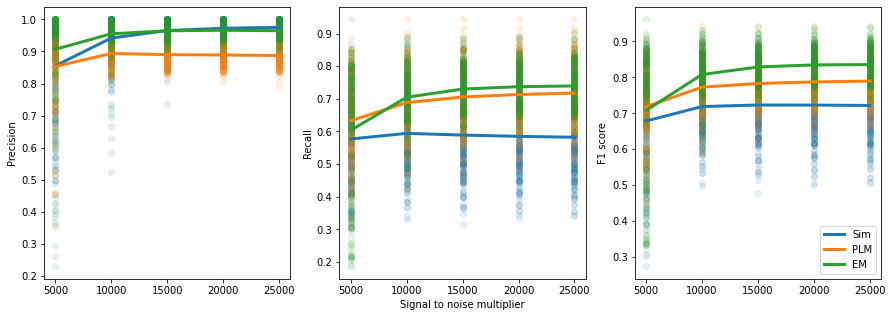

In [97]:
multiplier_mat = np.array([snr_list]*num_images).T

alpha = 0.1
lw=3

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(multiplier_mat,prec_snr_sim,alpha=alpha)
ax[0].scatter(multiplier_mat,prec_snr_plm,alpha=alpha)
ax[0].scatter(multiplier_mat,prec_snr_em,alpha=alpha)

ax[0].plot(snr_list,[np.mean(item) for item in prec_snr_sim],linewidth=lw)
ax[0].plot(snr_list,[np.mean(item) for item in prec_snr_plm],linewidth=lw)
ax[0].plot(snr_list,[np.mean(item) for item in prec_snr_em],linewidth=lw)

ax[1].scatter(multiplier_mat,recall_snr_sim,alpha=alpha)
ax[1].scatter(multiplier_mat,recall_snr_plm,alpha=alpha)
ax[1].scatter(multiplier_mat,recall_snr_em,alpha=alpha)

ax[1].plot(snr_list,[np.mean(item) for item in recall_snr_sim],linewidth=lw)
ax[1].plot(snr_list,[np.mean(item) for item in recall_snr_plm],linewidth=lw)
ax[1].plot(snr_list,[np.mean(item) for item in recall_snr_em],linewidth=lw)

ax[2].scatter(multiplier_mat,f1_snr_sim,alpha=alpha)
ax[2].scatter(multiplier_mat,f1_snr_plm,alpha=alpha)
ax[2].scatter(multiplier_mat,f1_snr_em,alpha=alpha)

ax[2].plot(snr_list,[np.mean(item) for item in f1_snr_sim],linewidth=lw,label='Sim')
ax[2].plot(snr_list,[np.mean(item) for item in f1_snr_plm],linewidth=lw,label='PLM')
ax[2].plot(snr_list,[np.mean(item) for item in f1_snr_em],linewidth=lw,label='EM')

plt.legend()
ax[1].set_xlabel('Signal to noise multiplier')
ax[0].set_ylabel('Precision')
ax[1].set_ylabel('Recall')
ax[2].set_ylabel('F1 score')
plt.show()

In [98]:
ind=0

threshold_list = [0.1,0.3,0.5,0.7,0.9,0.95]

prec_thresh_sim = []
recall_thresh_sim = []
f1_thresh_sim = []
error_thresh_sim = []

for i in range(len(threshold_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(sim_pred_all[2], ind, threshold_list[i])
        stats_dict = stats_points(coords_all[2][ind],points_list2,threshold_list[i])
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_thresh_sim.append(prec)
    recall_thresh_sim.append(recall)
    f1_thresh_sim.append(f1)
    error_thresh_sim.append(error)
    

prec_thresh_sim = np.array(prec_thresh_sim)
recall_thresh_sim = np.array(recall_thresh_sim)
f1_thresh_sim = np.array(f1_thresh_sim)
error_thresh_sim = np.array(error_thresh_sim)

In [99]:
ind=0

prec_thresh_plm = []
recall_thresh_plm = []
f1_thresh_plm = []
error_thresh_plm = []

for i in range(len(threshold_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(plm_pred_all[2], ind, threshold_list[i])
        stats_dict = stats_points(coords_all[2][ind],points_list2,threshold_list[i])
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_thresh_plm.append(prec)
    recall_thresh_plm.append(recall)
    f1_thresh_plm.append(f1)
    error_thresh_plm.append(error)
    

prec_thresh_plm = np.array(prec_thresh_plm)
recall_thresh_plm = np.array(recall_thresh_plm)
f1_thresh_plm = np.array(f1_thresh_plm)
error_thresh_plm = np.array(error_thresh_plm)

In [100]:
ind=0

prec_thresh_em = []
recall_thresh_em = []
f1_thresh_em = []
error_thresh_em = []

for i in range(len(threshold_list)):
    
    prec = []
    recall = []
    f1 = []
    error = []
    
    for ind in range(num_images):

        points_list2 = y_annotations_to_point_list2(em_pred_all[2], ind, threshold_list[i])
        stats_dict = stats_points(coords_all[2][ind],points_list2,threshold_list[i])
        
        prec.append(stats_dict['precision'])
        recall.append(stats_dict['recall'])
        f1.append(stats_dict['F1'])
        error.append(stats_dict['d_md'])
        
    prec_thresh_em.append(prec)
    recall_thresh_em.append(recall)
    f1_thresh_em.append(f1)
    error_thresh_em.append(error)
    

prec_thresh_em = np.array(prec_thresh_em)
recall_thresh_em = np.array(recall_thresh_em)
f1_thresh_em = np.array(f1_thresh_em)
error_thresh_em = np.array(error_thresh_em)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


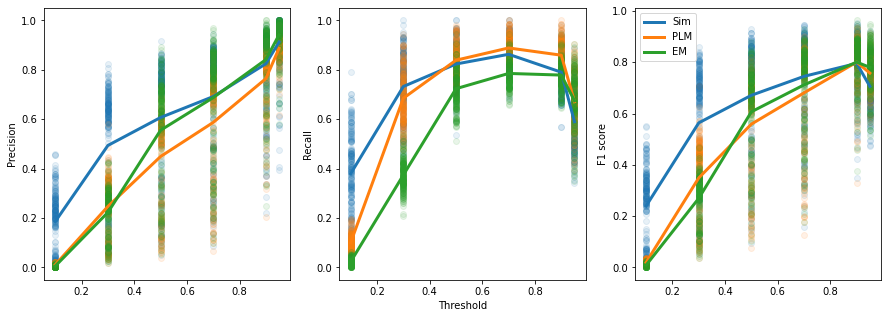

In [102]:
multiplier_mat = np.array([threshold_list]*num_images).T

alpha = 0.1
lw=3

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(multiplier_mat,prec_thresh_sim,alpha=alpha)
ax[0].scatter(multiplier_mat,prec_thresh_plm,alpha=alpha)
ax[0].scatter(multiplier_mat,prec_thresh_em,alpha=alpha)

ax[0].plot(threshold_list,[np.mean(item) for item in prec_thresh_sim],linewidth=lw)
ax[0].plot(threshold_list,[np.mean(item) for item in prec_thresh_plm],linewidth=lw)
ax[0].plot(threshold_list,[np.mean(item) for item in prec_thresh_em],linewidth=lw)

ax[1].scatter(multiplier_mat,recall_thresh_sim,alpha=alpha)
ax[1].scatter(multiplier_mat,recall_thresh_plm,alpha=alpha)
ax[1].scatter(multiplier_mat,recall_thresh_em,alpha=alpha)

ax[1].plot(threshold_list,[np.mean(item) for item in recall_thresh_sim],linewidth=lw)
ax[1].plot(threshold_list,[np.mean(item) for item in recall_thresh_plm],linewidth=lw)
ax[1].plot(threshold_list,[np.mean(item) for item in recall_thresh_em],linewidth=lw)

ax[2].scatter(multiplier_mat,f1_thresh_sim,alpha=alpha)
ax[2].scatter(multiplier_mat,f1_thresh_plm,alpha=alpha)
ax[2].scatter(multiplier_mat,f1_thresh_em,alpha=alpha)

ax[2].plot(threshold_list,[np.mean(item) for item in f1_thresh_sim],linewidth=lw,label='Sim')
ax[2].plot(threshold_list,[np.mean(item) for item in f1_thresh_plm],linewidth=lw,label='PLM')
ax[2].plot(threshold_list,[np.mean(item) for item in f1_thresh_em],linewidth=lw,label='EM')

plt.legend()
ax[1].set_xlabel('Threshold')
ax[0].set_ylabel('Precision')
ax[1].set_ylabel('Recall')
ax[2].set_ylabel('F1 score')
plt.show()